In [1]:
%matplotlib notebook
%load_ext autoreload
%autoreload 2

In [2]:
import copy
import glob
import warnings
import numpy as np
import pylab as plt

from skimage import morphology
from scipy.ndimage import binary_dilation

from astropy.io import fits
from astropy.time import Time
from natsort import natsorted
from astropy.stats import sigma_clip
from astropy.convolution import Gaussian2DKernel, convolve

import open3d as o3d

# Make sure we can find lassi-analysis
import sys
sys.path.append('/home/scratch/psalas/LASSI/lassi-analysis_v2')

from rotate import shiftRotateXYZ
from parabolas import loadLeicaData, fitParabola, parabola, fitLeicaData
from grid import regridXYZ, regridXYZMasked
from plotting import surfacePlot, barChartPlot, scatterPlot
from utils.utils import midPoint, radialMask, gridLimits, maskDiff
from zernikies import zernikeWLS, getZernikeCoeffs, zernikePoly, zernikeFitLS
from analyzeActiveSurface import processActiveSurfaceFITSPair
from analysis.March2020.zernike import make_aperture_efficiency, aperture_efficiency_residuals

/home/scratch/psalas/LASSI/lassi-analysis_v2/psalas_lassi_env/lib/python3.7/site-packages/dask/config.py:129: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  data = yaml.load(f.read()) or {}


In [3]:
def parabolaFitIterations(x, y, z, guess=[60., 0, 0, -50., 0, 0], bounds=None, iters=2, 
                          max_nfev=10000, ftol=1e-12, xtol=1e-15, f_scale=1e-4):
    
    mask = np.isnan(z)
    
    for i in range(iters):
        
        x_ = np.ma.masked_where(mask, x)
        y_ = np.ma.masked_where(mask, y)
        z_ = np.ma.masked_where(mask, z)
        
        fit = fitLeicaData(x_.compressed(), y_.compressed(), z_.compressed(), 
                           guess, bounds=bounds, f_scale=f_scale, ftol=ftol, 
                           xtol=xtol, max_nfev=max_nfev)
        
        xdr, ydr, zdr = alignXYZ(x, y, z, fit.x)
        
        zp = parabola(xdr, ydr, fit.x[0])
        
        with warnings.catch_warnings():
            warnings.simplefilter("ignore")
            res = sigma_clip(zdr - zp)
        mask = binary_dilation(res.mask, iterations=2)
        guess = fit.x
    
    return fit, mask

def prepareData(filename, n=512, rot=178.):
    orgData, cleanData = loadLeicaData(filename, n=None, numpy=False)
    x = orgData[0]
    y = orgData[1]
    z = orgData[2]
    xg, yg, zg = regridXYZ(x, y, z, n=n)
    xg, yg, zg = shiftRotateXYZ(xg, yg, zg, [0, 0, 0, 0, 0, np.deg2rad(rot)])
    
    return xg, yg, zg

def maskLoop(diff):
    mask = maskDiff(diff, window=(20,20), threshold=2)
    mDiff = np.ma.masked_where(mask, diff)
    b = morphology.remove_small_holes(mDiff.mask, area_threshold=64)
    mDiff = np.ma.masked_where(b, mDiff)
    return mDiff

def maskData(diff):
    mDiff = maskLoop(diff)
    #mDiff = np.ma.masked_outside(mDiff, -5e-3, 5e-3)
    mDiff = maskLoop(diff)
    return mDiff

def alignXYZ(x, y, z, fit):
    cor = np.hstack((-1*fit[1:4],fit[4:6],0))
    xr, yr, zr = shiftRotateXYZ(x, y, z, cor)
    return xr, yr, zr

In [73]:
n = 512
rot = 179.5
iters = 1
guess = [6.00319194e+01, 2.464, -0.914, -4.92e+01, 2.19754536e-01, 5.02049715e-04]
guess = [6.00319194e+01, 2.45282692e+00, -9.96895755e-01, -4.92e+01, 2.19838173e-01, -5.05770158e-03]
kernel = Gaussian2DKernel(x_stddev=17.)
nZern = 36
maskIters = 3
iz = 4
izv = -167
zcoef = np.zeros(nZern)
zcoef[iz] = izv
scanDir = '/home/scratch/psalas/LASSI/gpus/output/'

In [74]:
%%time
refScan = "{0}/2020_03_16_ref_average.ptx.csv".format(scanDir)
#refScan = "{0}/2020_03_16_02:54:59.ptx.csv".format(scanDir)
#refScan = "{0}/2020_03_16_06:11:20.ptx.csv".format(scanDir)
xr, yr, zr = prepareData(refScan, n=n, rot=rot)

CPU times: user 7.7 s, sys: 1.43 s, total: 9.13 s
Wall time: 6.65 s


In [75]:
%%time
#sigScan = "{0}/2020_03_16_02:28:31.ptx.csv".format(scanDir) # C4=-518
#sigScan = "{0}/2020_03_16_03:02:51.ptx.csv".format(scanDir) # C4=-486
sigScan = "{0}/2020_03_16_03:27:25.ptx.csv".format(scanDir) # C4=-167
#sigScan = "{0}/2020_03_16_06:43:17.ptx.csv".format(scanDir) # C4=-562
#sigScan = "{0}/2020_03_16_02:21:06.ptx.csv".format(scanDir) # Ref scan
#sigScan = "{0}/2020_03_16_07:56:13.ptx.csv".format(scanDir) # C7=-554
#sigScan = "{0}/2020_03_16_05:30:05.ptx.csv".format(scanDir) # C13=-534
xs, ys, zs = prepareData(sigScan, n=n, rot=rot)

CPU times: user 3.62 s, sys: 772 ms, total: 4.4 s
Wall time: 2.86 s


In [76]:
inf = np.inf
pi2 = 2*np.pi
b1 = [59., -inf, -inf, -49.2-1e-4, -pi2, -pi2]
b2 = [61.,  inf,  inf, -49.2+1e-4,  pi2,  pi2]
bounds = (b1, b2)
bounds = None

In [77]:
%%time
zrs = convolve(zr, kernel, boundary='extend', fill_value=0.0, nan_treatment='interpolate', 
                normalize_kernel=True, mask=None, preserve_nan=True, normalization_zero_tol=1e-08)
zrsFit, zrsMask = parabolaFitIterations(xr, yr, zrs,
                                        guess=guess, bounds=bounds, iters=6, 
                                        max_nfev=10000, ftol=1e-10, xtol=1e-10, f_scale=1e-5)
zss = convolve(zs, kernel, boundary='extend', fill_value=0.0, nan_treatment='interpolate', 
                normalize_kernel=True, mask=None, preserve_nan=True, normalization_zero_tol=1e-08)
zssFit, zssMask = parabolaFitIterations(xs, ys, zss,
                                        guess=guess, bounds=bounds, iters=6, 
                                        max_nfev=10000, ftol=1e-10, xtol=1e-10, f_scale=1e-5)
print(zrsFit.x)
print(zssFit.x)

[ 6.00535434e+01  2.47126359e+00 -9.26362474e-01 -4.92015503e+01
  2.19860353e-01  5.80425273e-04]
[ 6.00581332e+01  2.46970962e+00 -9.22833495e-01 -4.92002118e+01
  2.19809326e-01  5.75579898e-04]
CPU times: user 7min 35s, sys: 6min 35s, total: 14min 10s
Wall time: 51.2 s


In [78]:
pFitR = np.copy(zrsFit.x)
pFitS = np.copy(zssFit.x)
xra, yra, zra = alignXYZ(xr, yr, zr, pFitR)
xsa, ysa, zsa = alignXYZ(xs, ys, zs, pFitS)

In [79]:
%%time
xmin, xmax = gridLimits(xsa, xra)
ymin, ymax = gridLimits(ysa, yra)
xrag, yrag, zrag = regridXYZ(xra, yra, zra, n=n, xmin=xmin, xmax=xmax, ymin=ymin, ymax=ymax)
xsag, ysag, zsag = regridXYZ(xsa, ysa, zsa, n=n, xmin=xmin, xmax=xmax, ymin=ymin, ymax=ymax)

CPU times: user 10.9 s, sys: 2.55 s, total: 13.4 s
Wall time: 8.49 s


/home/scratch/psalas/LASSI/lassi-analysis_v2/utils/utils.py:131: RuntimeWarning: invalid value encountered in greater
  mask = (np.ma.abs(diff - diff_avg)/diff_rms > threshold) | (diff_rms == 0)
/home/scratch/psalas/LASSI/lassi-analysis_v2/utils/utils.py:131: RuntimeWarning: invalid value encountered in greater
  mask = (np.ma.abs(diff - diff_avg)/diff_rms > threshold) | (diff_rms == 0)


<IPython.core.display.Javascript object>


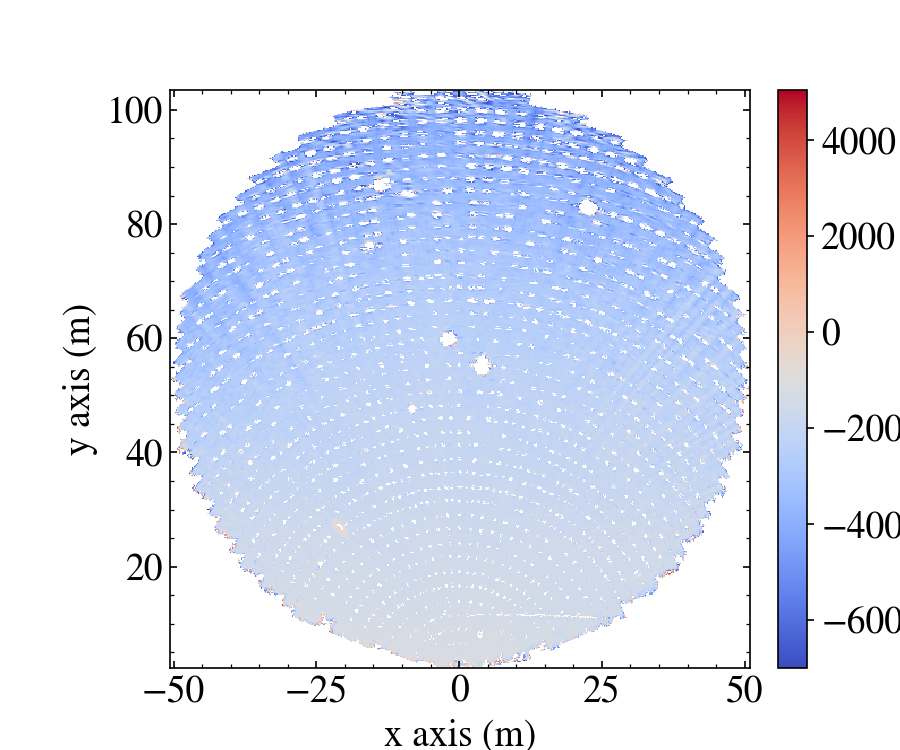

In [80]:
diff = np.ma.masked_invalid(zsag - zrag)
diff = np.ma.masked_outside(diff, -7e-3, 7e-3)
diff = maskData(diff)
vmin = np.nanmin(diff*1e6)
vmax = np.nanmax(diff*1e6)
surfacePlot(xrag, yrag, diff.T*1e6, vMin=vmin, vMax=vmax, midPoint=(vmin+vmax)*0.5)

In [81]:
def xyz2pcld(x, y, z):
    """
    """
    x_ = x[~np.isnan(z)]
    y_ = y[~np.isnan(z)]
    z_ = z[~np.isnan(z)]
    
    xyz = np.zeros((np.size(z_), 3))
    xyz[:, 0] = np.reshape(x_, -1)
    xyz[:, 1] = np.reshape(y_, -1)
    xyz[:, 2] = np.reshape(z_, -1)
    
    pcld = o3d.geometry.PointCloud()
    pcld.points = o3d.utility.Vector3dVector(xyz)
    
    return pcld

<IPython.core.display.Javascript object>


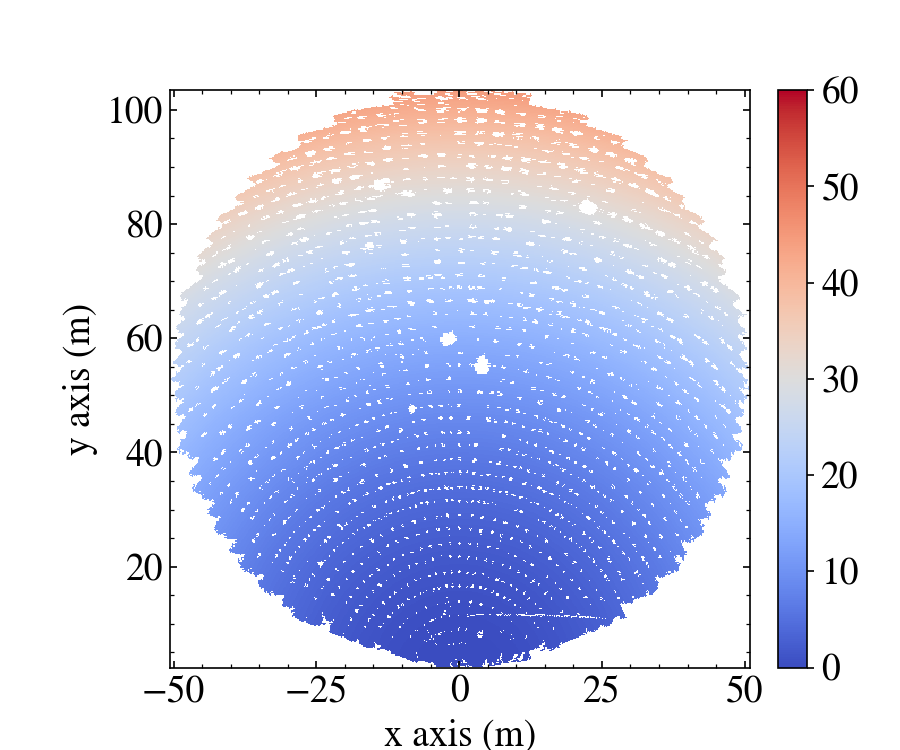

In [82]:
mask = np.isnan(zrag) | np.isnan(zsag) | diff.mask
zrag[mask] = np.nan
zsag[mask] = np.nan
surfacePlot(xrag, yrag, zrag.T, vMin=0, vMax=60, midPoint=30)

In [83]:
ref_pcld = xyz2pcld(xrag, yrag, zrag)
sig_pcld = xyz2pcld(xsag, ysag, zsag)

In [84]:
%%time
# Create point clouds of the smoothed aligned data.
zrags = convolve(zrag, kernel, boundary='extend', fill_value=0.0, nan_treatment='interpolate', 
                 normalize_kernel=True, mask=None, preserve_nan=True, normalization_zero_tol=1e-08)
zsags = convolve(zsag, kernel, boundary='extend', fill_value=0.0, nan_treatment='interpolate', 
                 normalize_kernel=True, mask=None, preserve_nan=True, normalization_zero_tol=1e-08)
ref_smo_pcld = xyz2pcld(xrag, yrag, zrags)
sig_smo_pcld = xyz2pcld(xsag, ysag, zsags)

CPU times: user 14.3 s, sys: 2.7 ms, total: 14.3 s
Wall time: 14.3 s


In [85]:
threshold = 0.01

In [86]:
%%time
reg_p2p = o3d.registration.registration_icp(sig_smo_pcld, ref_smo_pcld, threshold,
          estimation_method=o3d.registration.TransformationEstimationPointToPoint())
          #estimation_method=o3d.registration.TransformationEstimationPointToPlane())

CPU times: user 3.38 s, sys: 637 ms, total: 4.01 s
Wall time: 259 ms


In [87]:
print(reg_p2p)
print("Transformation is:")
print(reg_p2p.transformation)

registration::RegistrationResult with fitness=1.000000e+00, inlier_rmse=3.457625e-04, and correspondence_set size of 187920
Access transformation to get result.
Transformation is:
[[ 1.00000000e+00 -2.90748442e-07  1.22829501e-06 -5.07832252e-06]
 [ 2.90778638e-07  1.00000000e+00 -2.45836798e-05  4.07573784e-04]
 [-1.22828786e-06  2.45836801e-05  1.00000000e+00  1.15854651e-03]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]]


In [88]:
sig_reg = copy.deepcopy(sig_pcld)
sig_reg.transform(reg_p2p.transformation)

geometry::PointCloud with 187920 points.

In [89]:
xyz_sig = np.asarray(sig_reg.points)
xyz_ref = np.asarray(ref_pcld.points)

In [90]:
xsr, ysr, zsr = xyz_sig.T
xrr, yrr, zrr = xyz_ref.T

In [91]:
%%time
xmin, xmax = gridLimits(xsr, xrr)
ymin, ymax = gridLimits(ysr, yrr)
xrrg, yrrg, zrrg = regridXYZ(xrr, yrr, zrr, n=n, xmin=xmin, xmax=xmax, ymin=ymin, ymax=ymax)
xsrg, ysrg, zsrg = regridXYZ(xsr, ysr, zsr, n=n, xmin=xmin, xmax=xmax, ymin=ymin, ymax=ymax)

CPU times: user 10.9 s, sys: 2.02 s, total: 12.9 s
Wall time: 9.18 s


<IPython.core.display.Javascript object>


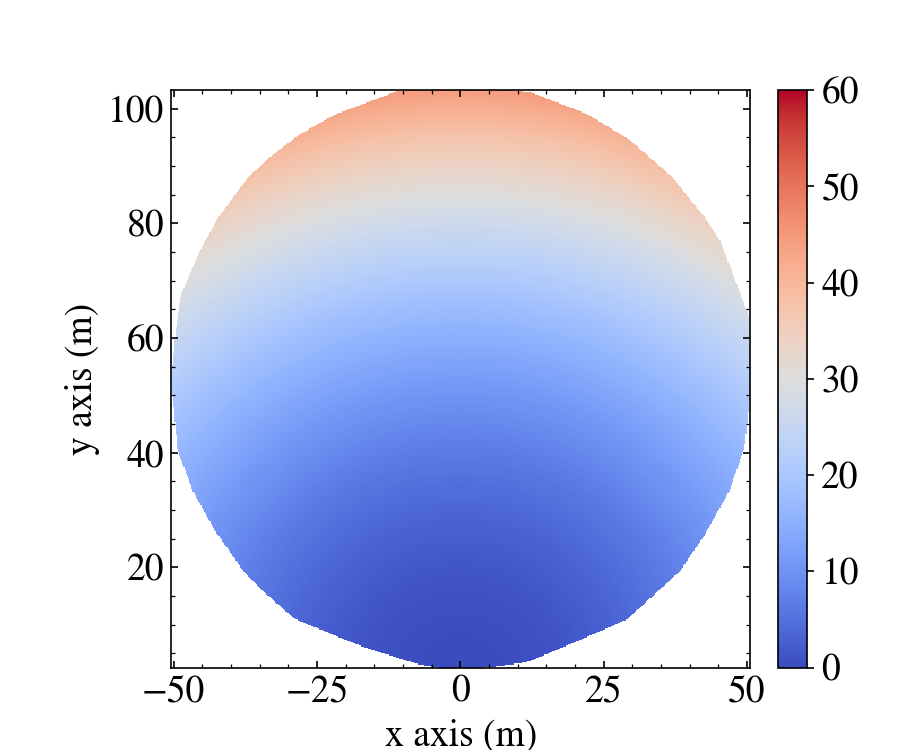

<IPython.core.display.Javascript object>


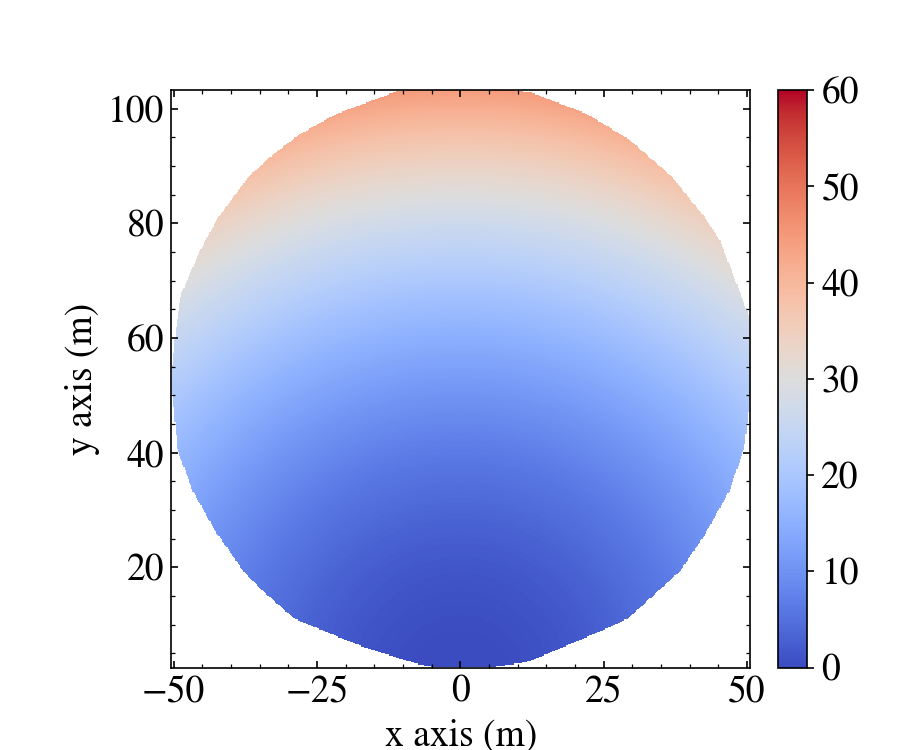

In [92]:
surfacePlot(xrrg, yrrg, zrrg.T, vMin=0, vMax=60, midPoint=30)
surfacePlot(xsrg, ysrg, zsrg.T, vMin=0, vMax=60, midPoint=30)

/home/scratch/psalas/LASSI/lassi-analysis_v2/utils/utils.py:131: RuntimeWarning: invalid value encountered in greater
  mask = (np.ma.abs(diff - diff_avg)/diff_rms > threshold) | (diff_rms == 0)
/home/scratch/psalas/LASSI/lassi-analysis_v2/utils/utils.py:131: RuntimeWarning: invalid value encountered in greater
  mask = (np.ma.abs(diff - diff_avg)/diff_rms > threshold) | (diff_rms == 0)


<IPython.core.display.Javascript object>


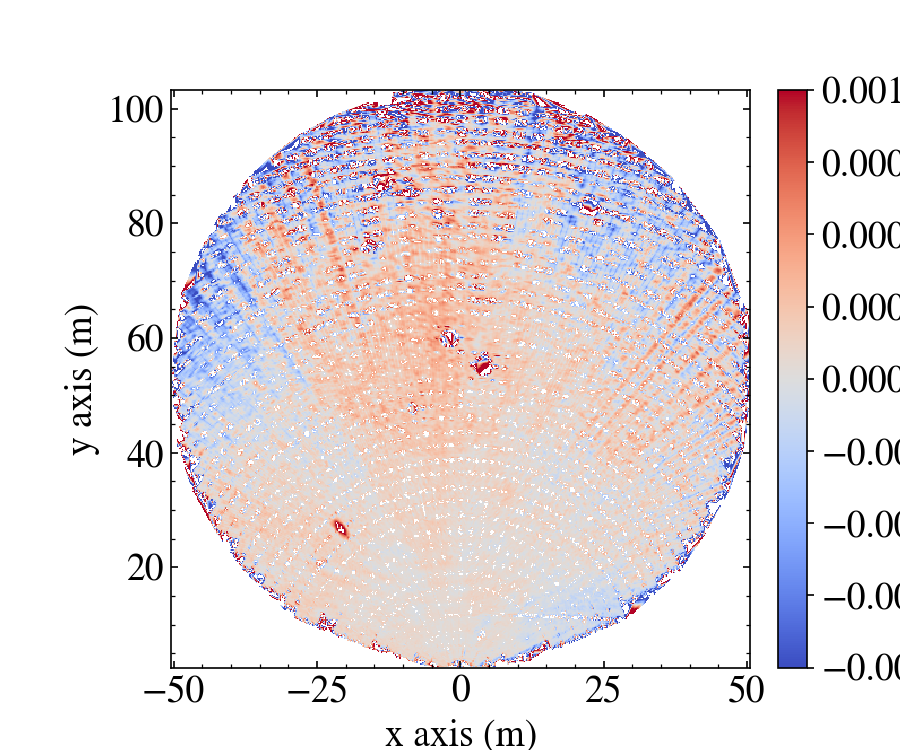

In [93]:
diff = np.ma.masked_invalid(zsrg - zrrg)
#diff = np.ma.masked_outside(diff, -1e-3, 1e-3)
diff = sigma_clip(diff, 5)
diff = maskData(diff)
surfacePlot(xrrg, yrrg, diff.T, vMin=-1e-3, vMax=1e-3, midPoint=0)

<IPython.core.display.Javascript object>


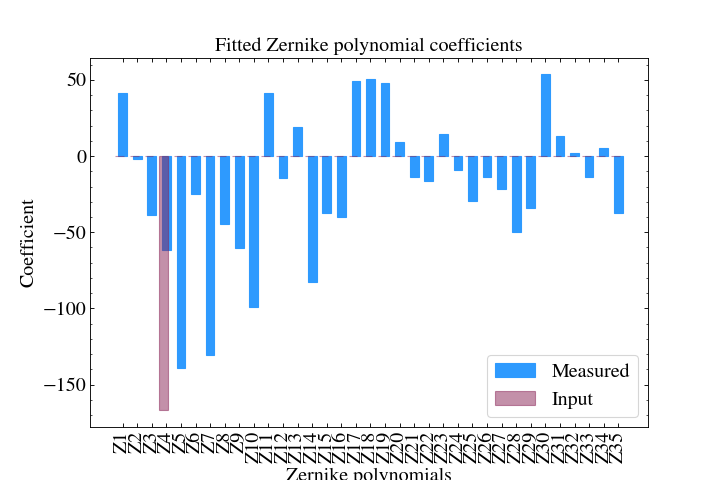

-61.99170837842639


In [94]:
fl_fs = getZernikeCoeffs(diff.filled(0)[::-1].T, 36, norm='active-surface')
barChartPlot(np.arange(1,36), fl_fs[1:36]*1e6, expected=zcoef[1:36])
print(fl_fs[iz]*1e6)